In [1]:
import numpy as np
import sys
import itertools as itertools
sys.path.append("..")
sys.path.append("../..")

import matplotlib.pyplot as plt
from python.Heisenberg import *
from python.DMRG import DMRG
from python.Zippers import MPO_to_Hamiltonian, contract_MPS
from python.Canonical_Form import get_Neumann_entropy
from python.Backend import Backend
from python.Decomposition import EIGH

In [2]:
bk = Backend("numpy")
# bk = Backend("torch")

NKeep = 50
NSweep = 20
Krylov_bases = 5  #* 5 is usually enough
Lanczos_cutoff = 1e-2
two_site = True
verbose = True

# AFM XXZ model ground state energy

In [3]:
n_sites_lists = np.array([64, 128, 256, 512, 1024, 2048])

XY_coupling = 1.0
ZZ_coupling = 1.0
magnetic_field = 0.0

ground_state_energies = []

for n_sites in n_sites_lists:
    Hamiltonian = XXZ_model(
        bk=bk, n_sites=n_sites, ZZ_coupling=ZZ_coupling,
        XY_coupling=XY_coupling, magnetic_field=magnetic_field,
    )
    
    ground_energies, ground_times, ground_MPS = DMRG(
        bk = bk,
        Hamiltonian = Hamiltonian,
        NKeep = NKeep,
        NSweep = NSweep,
        Krylov_bases = Krylov_bases,
        Lanczos_cutoff = Lanczos_cutoff,
        iterative_diag = True,
        two_site = two_site,
        verbose = verbose,
        tol = 1e-8,
    )
    
    ground_state_energies.append(ground_energies[-1])

ground_state_energies = np.array(ground_state_energies)


L=64 | NKeep=50 | NSweep=20 | diag=True | two=True | Krylov=5 | cutoff=0.01
Iterative diagonalization complete
iter=0 | energy=-28.167071 | time=0js
iter=1 | energy=(-28.175344219455454+0j) | time=4.438778701000047s
iter=2 | energy=(-28.175344219455862+0j) | time=9.18846307800004s
L=128 | NKeep=50 | NSweep=20 | diag=True | two=True | Krylov=5 | cutoff=0.01
Iterative diagonalization complete
iter=0 | energy=-56.524433 | time=0js
iter=1 | energy=(-56.53534749579747+0j) | time=12.889721713999961s
iter=2 | energy=(-56.53534749579696+0j) | time=19.172334670000055s
L=256 | NKeep=50 | NSweep=20 | diag=True | two=True | Krylov=5 | cutoff=0.01
Iterative diagonalization complete
iter=0 | energy=-113.24436 | time=0js
iter=1 | energy=(-113.2572350373303+0j) | time=12.67708464999987s
iter=2 | energy=(-113.25723503733369+0j) | time=33.295037760000014s
L=512 | NKeep=50 | NSweep=20 | diag=True | two=True | Krylov=5 | cutoff=0.01
Iterative diagonalization complete
iter=0 | energy=-226.68814 | time=0js


/home/sungbinlee/miniconda3/envs/latest/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sungbinlee/miniconda3/envs/latest/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sungbinlee/miniconda3/envs/latest/lib/python3.11/site-packages/numpy/lib/function_base.py:626: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


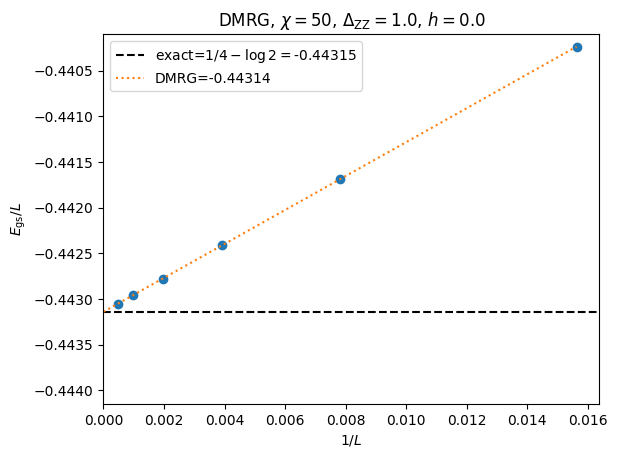

In [4]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.errorbar(1/n_sites_lists, ground_state_energies/n_sites_lists, fmt="o")

plt.title(rf"DMRG, $\chi={NKeep}$, $\Delta_\mathrm{{ZZ}}=1.0$, $h=0.0$")

plt.xlabel(r"$1/L$")
plt.ylabel(r"$E_\mathrm{gs}/L$")

plt.xlim(0, None)
plt.ylim(1/4-np.log(2)-1e-3, None)
plt.axhline(1/4-np.log(2), linestyle="--", color="black", label=rf"exact=$1/4-\log{{2}}=${round(1/4-np.log(2), 5)}")

def linear_line(x, a, b):
    return a + b*x

params, _ = curve_fit(linear_line, 1/n_sites_lists, ground_state_energies/n_sites_lists)

x_lines = np.linspace(0, 1/n_sites_lists[0], 100)

plt.errorbar(x_lines, linear_line(x_lines, *params), fmt=":", label=f"DMRG={round(params[0],5)}")

plt.legend()


In [5]:
total_charge = []
    
identity = bk.identity(4)

annihilation_up = bk.zeros([4, 4])
annihilation_up[0,1] = 1.0
annihilation_up[2,3] = -1.0

annihilation_down = bk.zeros([4, 4])
annihilation_down[0,2] = 1.0
annihilation_down[1,3] = 1.0

creation_up = annihilation_up.conj().T

creation_down = annihilation_down.conj().T

density_up = creation_up @ annihilation_up

density_down = creation_down @ annihilation_down

density_total = density_up + density_down

In [6]:
density_total

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 2.+0.j]])

In [7]:
total_spin_operator = -3 / 4 * ((identity - density_total) @ (identity - density_total) - identity)